In [1]:
#!pip install newsapi-python
#!pip install statsmodels
#!pip install pmdarima
#!pip install tweepy
#!pip install python-dotenv
# !pip install boto3
# !pip install deep_translator

# !pip install googletrans

In [1]:
from GoogleNews import GoogleNews
from newspaper import Article
from newsapi import NewsApiClient
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import json
import csv
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels as sm
import random
import os
import tweepy
from dotenv import load_dotenv
from pathlib import Path
import time
from deep_translator import GoogleTranslator
from googletrans import Translator
import warnings
warnings.filterwarnings('ignore')
from translate import Translator

In [5]:
newsapi = NewsApiClient(api_key='dd050f33108f4797a7e056ae3543c907')


In [6]:
all_articles = newsapi.get_everything(q='amazon',
                                      from_param='2022-10-27',
                                      to='2022-10-28',
                                      language='en',
                                      sort_by='relevancy')

In [7]:
# json_all_article = json.loads(all_articles)

print(json.dumps(all_articles, indent = 5))

{
     "status": "ok",
     "totalResults": 3255,
     "articles": [
          {
               "source": {
                    "id": "engadget",
                    "name": "Engadget"
               },
               "author": "Jon Fingas",
               "title": "Sony's WH-XB910N ANC headphones are 51 percent off right now",
               "description": "Now's your chance to get a pair of solid noise-cancelling headphones without the usual high price. Amazon is selling the WH-XB910N with active noise cancellation (ANC) for $123, or a hefty 51 percent off. That's a better deal than we saw earlier this year, an\u2026",
               "url": "https://www.engadget.com/sony-wh-xb910n-anc-headphones-best-price-134525061.html",
               "urlToImage": "https://s.yimg.com/os/creatr-uploaded-images/2022-10/94cfcc40-56bc-11ed-bfff-894fb4358636",
               "publishedAt": "2022-10-28T13:45:25Z",
               "content": "Now's your chance to get a pair of solid noise-cancelling head

In [8]:
print(all_articles["articles"][25]["title"])

Amazon joins Big Tech's dark forecast for the rest of the year. It said next quarter's sales will be less than expected – and its stock just plummeted 17%


In [11]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import torch


# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"


tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
#tokenizer.save_pretrained(MODEL)



In [12]:
def getSentiment(text):
    if text == None:
        return [0,1,0];
    #text = "Big Tech is getting wiped out in a brutal 3rd-quarter earnings season - but Apple isn't. Here's why."
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # # TF
    # model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
    # model.save_pretrained(MODEL)

    # text = "Good night 😊"
    # encoded_input = tokenizer(text, return_tensors='tf')
    # output = model(encoded_input)
    # scores = output[0][0].numpy()
    # scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    sentiment = [0,0,0]
    index = {"negative": 0, "neutral": 1, "positive": 2}
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        sentiment[index[l]] = s
        #print(f"{i + 1}) {l} {np.round(float(s), 4)}")
    return sentiment

In [13]:
getSentiment("Apple sold slightly fewer iPhones than expected, but Tim Cook says the economy isn't yet affecting sales \u2013 bucking the Big Tech bad-news trend")

[0.11756228, 0.46866465, 0.41377312]

In [12]:
#!pip install torch

In [13]:
!pip install numpy --upgrade



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
np.__version__

'1.23.4'

In [15]:
all_articles_title_sentiments = []
all_articles_description_sentiments = []
all_articles_content_sentiments = []
all_articles_source = []
for article in all_articles["articles"]:
#     print(article["title"])
#     [negative, neutral, positive]
    all_articles_title_sentiments.append(getSentiment(article["title"]))
    all_articles_description_sentiments.append(getSentiment(article["description"]))
    all_articles_content_sentiments.append(getSentiment(article["content"]))
    all_articles_source.append(getSentiment(article["source"]["id"]))

In [16]:
print(all_articles_title_sentiments)

[[0.009099913, 0.547598, 0.44330207], [0.11504678, 0.8173986, 0.06755463], [0.172367, 0.78666574, 0.04096723], [0.3723734, 0.54514277, 0.082483865], [0.38321707, 0.5340558, 0.082727164], [0.012062055, 0.37494552, 0.6129924], [0.6650598, 0.2892899, 0.04565034], [0.0008476415, 0.032014567, 0.9671378], [0.015692016, 0.25744352, 0.72686446], [0.2553107, 0.7060299, 0.038659435], [0.007821409, 0.77460647, 0.21757208], [0.48440415, 0.4814672, 0.034128614], [0.6588518, 0.31997234, 0.021175832], [0.67388976, 0.3054291, 0.020681173], [0.059895195, 0.40732235, 0.53278244], [0.4519017, 0.3985867, 0.14951164], [0.009140224, 0.112065874, 0.8787939], [0.089538164, 0.81738293, 0.09307897], [0.49452484, 0.42489713, 0.08057806], [0.3879229, 0.5096048, 0.10247225], [0.8681332, 0.123484135, 0.008382631], [0.019069899, 0.42233428, 0.55859584], [0.5423826, 0.4153176, 0.042299803], [0.19932121, 0.7306923, 0.06998652], [0.57840294, 0.3612192, 0.060377862], [0.86337173, 0.124132164, 0.012496099], [0.01842417, 

In [17]:
all_articles_title_sentiments_numpy = np.array(all_articles_title_sentiments)
all_articles_description_sentiments_numpy = np.array(all_articles_description_sentiments)
all_articles_content_sentiments_numpy = np.array(all_articles_content_sentiments)
all_articles_source_numpy = np.array(all_articles_source)

In [18]:
all_articles_title_sentiments_numpy_sum = np.sum(all_articles_title_sentiments_numpy, axis = 0)
all_articles_description_sentiments_numpy_sum = np.sum(all_articles_description_sentiments_numpy, axis = 0)
all_articles_content_sentiments_numpy_sum = np.sum(all_articles_content_sentiments_numpy, axis = 0)

In [19]:
print(all_articles_title_sentiments_numpy_sum)
print(all_articles_description_sentiments_numpy_sum)
print(all_articles_content_sentiments_numpy_sum)


[18.383741 46.174175 35.442074]
[21.999205 35.64954  42.351246]
[18.956602 40.870117 40.17326 ]


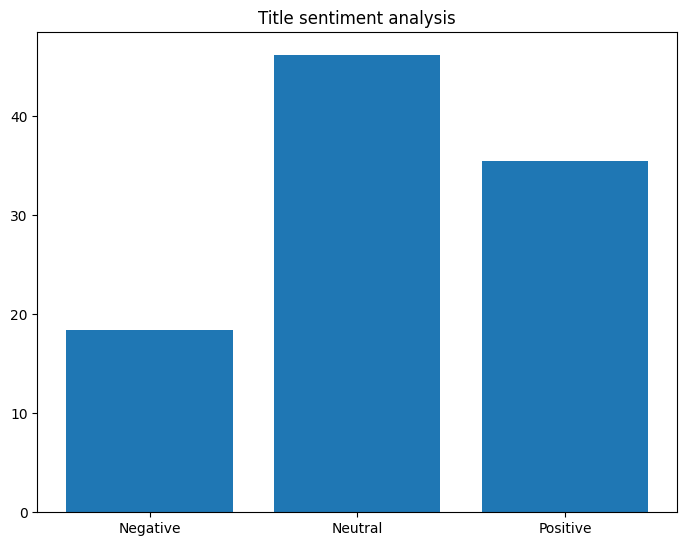

In [20]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiment = ['Negative', 'Neutral', 'Positive']
ax.bar(sentiment,all_articles_title_sentiments_numpy_sum)
plt.title("Title sentiment analysis")
plt.show()

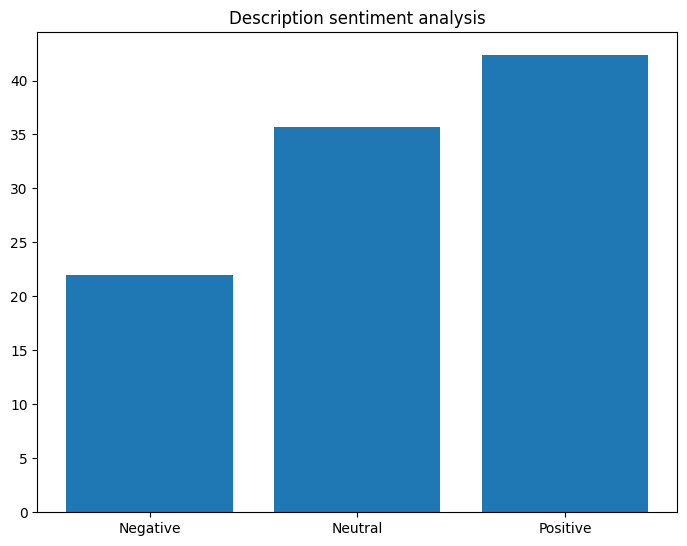

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiment = ['Negative', 'Neutral', 'Positive']
plt.title("Description sentiment analysis")
ax.bar(sentiment,all_articles_description_sentiments_numpy_sum)
plt.show()

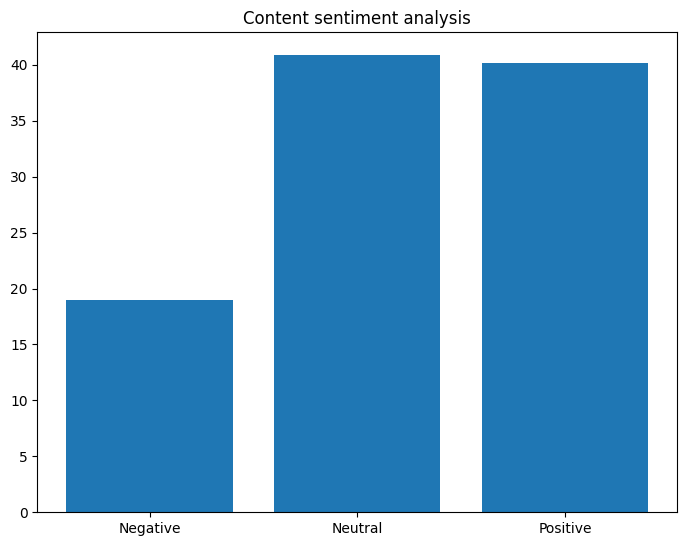

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiment = ['Negative', 'Neutral', 'Positive']
ax.bar(sentiment,all_articles_content_sentiments_numpy_sum)
plt.title("Content sentiment analysis")
plt.show()

In [23]:

date = '2022-10-28'
# date = dateparser.parse(date, date_formats=['%Y %M %d'])
date = datetime.strptime(date, '%Y-%m-%d')
print(date)
previous_date = date - timedelta(days=3)
print(previous_date)

2022-10-28 00:00:00
2022-10-25 00:00:00


In [24]:
amzn = pd.read_csv("data/stock_price_yahoo/AMZN.csv")

In [25]:
amzn.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [26]:
company_day_one = datetime.strptime(amzn.iloc[0][0], '%Y-%m-%d')
for row in amzn.iterrows():
#     print(row[1][0])
    date = datetime.strptime(row[1][0], '%Y-%m-%d')
    prev_date = date - timedelta(days=1)
    prev_month = prev_date - timedelta(days=30)
    prev_year = prev_month - timedelta(days=365)
    print(date.strftime("%Y-%m-%d"))
    print(prev_date.strftime("%Y-%m-%d"))
    print(prev_month.strftime("%Y-%m-%d"))
    print(prev_year.strftime("%Y-%m-%d"))
    break

1997-05-15
1997-05-14
1997-04-14
1996-04-14


In [27]:
# checking google api for long intervals
one_month_articles = newsapi.get_everything(q='amazon',
                                      from_param='2022-10-27',
                                      to='2022-10-15',
                                      language='en',
                                      sort_by='relevancy')

In [28]:
print(json.dumps(one_month_articles, indent = 5))

{
     "status": "ok",
     "totalResults": 16085,
     "articles": [
          {
               "source": {
                    "id": null,
                    "name": "Lifehacker.com"
               },
               "author": "Daniel Oropeza",
               "title": "These E-bikes From Amazon and Walmart Have Been Recalled",
               "description": "About 22,000 e-bikes sold online by Amazon, Walmart, eBay, Overstock, and Sears (among other retailers) have been recalled, the U.S. Consumer Product Safety Commission announced last week. The e-bikes\u2019 manufacturer, Ancheer, said it was issuing the voluntary \u2026",
               "url": "https://lifehacker.com/these-e-bikes-from-amazon-and-walmart-have-been-recalle-1849666901",
               "urlToImage": "https://i.kinja-img.com/gawker-media/image/upload/c_fill,f_auto,fl_progressive,g_center,h_675,pg_1,q_80,w_1200/f4e22d256e4e9cc79d2ed6ed7f1366e6.jpg",
               "publishedAt": "2022-10-17T15:30:00Z",
               "

In [29]:
subscription_key = "e1dce99948ac4ad9a4da36bb59f6efb7"
search_term = "Microsoft"
search_url = "https://api.bing.microsoft.com/v7.0/news/search"

In [30]:
headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
params  = {"q": search_term, "textDecorations": True, "textFormat": "HTML", "freshness": "Month"}

In [31]:
response = requests.get(search_url, headers=headers, params=params)
response.raise_for_status()
search_results = json.dumps(response.json())

In [32]:
print(json.dumps((json.loads(search_results)), indent = 5))

{
     "_type": "News",
     "readLink": "https://api.bing.microsoft.com/api/v7/news/search?q=Microsoft",
     "queryContext": {
          "originalQuery": "Microsoft",
          "adultIntent": false
     },
     "totalEstimatedMatches": 42,
     "sort": [
          {
               "name": "Best match",
               "id": "relevance",
               "isSelected": true,
               "url": "https://api.bing.microsoft.com/api/v7/news/search?q=Microsoft"
          },
          {
               "name": "Most recent",
               "id": "date",
               "isSelected": false,
               "url": "https://api.bing.microsoft.com/api/v7/news/search?q=Microsoft&sortby=date"
          }
     ],
     "value": [
          {
               "name": "<b>Microsoft</b>&#39;s Brad Smith Shares 4 Cybersecurity Tips for Small Businesses",
               "url": "https://www.inc.com/melissa-angell/small-business-administration-cyber-summit.html",
               "image": {
                    "t

In [33]:
news_json = json.loads(search_results)

In [34]:
news_json["value"][1]

{'name': '<b>Microsoft</b> promises to keep Call of Duty on PlayStation for as long as PlayStation exists',
 'url': 'https://www.msn.com/en-us/lifestyle/shopping/microsoft-promises-to-keep-call-of-duty-on-playstation-for-as-long-as-playstation-exists/ar-AA13AvfK',
 'image': {'thumbnail': {'contentUrl': 'https://www.bing.com/th?id=OVFT.gIIGfKaDPZUiFaETjPUEmC&pid=News',
   'width': 700,
   'height': 366}},
 'description': 'As long as there’s a PlayStation out there to ship to, our intent is that we continue to ship Call of Duty on PlayStation,” says Spencer on the Same Brain podcast. “Similar to what we’ve done with Minecraft,',
 'about': [{'readLink': 'https://api.bing.microsoft.com/api/v7/entities/a093e9b9-90f5-a3d5-c4b8-5855e1b01f85',
   'name': 'Microsoft'},
  {'readLink': 'https://api.bing.microsoft.com/api/v7/entities/2b485a35-f5af-47ad-5cee-6c53599255fe',
   'name': 'PlayStation'},
  {'readLink': 'https://api.bing.microsoft.com/api/v7/entities/ea104807-e8bd-68bf-a85b-c01c90fd5e18'

# Finally decided to stick with News API

In [35]:
#This gives 2000 results for one day out of which we can access only 100. Based on relevancy(I would say it is better that way)
all_articles = newsapi.get_everything(q='amazon',
                                      from_param='2022-10-27',
                                      to='2022-10-28',
                                      language='en',
                                      sort_by='relevancy')

In [36]:
def sentiment_analysis(all_articles):
    all_articles_title_sentiments = []
    all_articles_description_sentiments = []
    all_articles_content_sentiments = []
    all_articles_source = []
    for article in all_articles["articles"]:
    #     print(article["title"])
    #     [negative, neutral, positive]
        all_articles_title_sentiments.append(getSentiment(article["title"]))
        all_articles_description_sentiments.append(getSentiment(article["description"]))
        all_articles_content_sentiments.append(getSentiment(article["content"]))
        all_articles_source.append(getSentiment(article["source"]["id"]))
    all_articles_title_sentiments_numpy = np.array(all_articles_title_sentiments)
    all_articles_description_sentiments_numpy = np.array(all_articles_description_sentiments)
    all_articles_content_sentiments_numpy = np.array(all_articles_content_sentiments)
    all_articles_source_numpy = np.array(all_articles_source)
    all_articles_title_sentiments_numpy_sum = np.sum(all_articles_title_sentiments_numpy, axis = 0)
    all_articles_description_sentiments_numpy_sum = np.sum(all_articles_description_sentiments_numpy, axis = 0)
    all_articles_content_sentiments_numpy_sum = np.sum(all_articles_content_sentiments_numpy, axis = 0)
    return all_articles_title_sentiments_numpy_sum, all_articles_description_sentiments_numpy_sum, all_articles_content_sentiments_numpy_sum

In [37]:
#Now we need a mechanism with which we can fetch 1 week, 1 month, 1 year and 5 year data taking one day at a time
#Because free access gives us only that much info
def fetch_timeframe(days, start_date, search_query):
    day1 = start_date
    day2 = day1
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y_%H-%M-%S")
    path = 'data/news_sentiment_extracted/' + search_query + "_" + dt_string + '.csv'
    path = "one.csv"
    f = open(path, 'w+', newline='')
    writer = csv.writer(f)
    header = ['date', 'title_neg', 'title_neu', 'title_pos', 'description_neg', 'description_neu', 'description_pos', 'content_neg', 'content_neu', 'content_pos']
    writer.writerow(header)
    for i in range(days):
        day1 = day2
        day2 = day1 - timedelta(days=1)
        all_articles = newsapi.get_everything(q=search_query,
                                     from_param=day2,
                                     to=day1,
                                     language='en',
                                     sort_by='relevancy')
        print("from ",day1," to ", day2, " number of articles: ", all_articles["totalResults"])
        title, description, content = sentiment_analysis(all_articles)
        print("title: ", title)
        print("description: ", description)
        print("content: ", content)
        date = day1.strftime("%d/%m/%Y %H:%M:%S")
        data = [date, title[0], title[1], title[2], description[0], description[1], description[2], content[0], content[1], content[2]]
        writer.writerow(data)

In [38]:
date = '2015-10-28'
# date = dateparser.parse(date, date_formats=['%Y %M %d'])
date = datetime.strptime(date, '%Y-%m-%d')
print(date)
fetch_timeframe(2, date, "amazon")

2015-10-28 00:00:00


NewsAPIException: {'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2022-09-29, but you have requested 2015-10-27. You may need to upgrade to a paid plan.'}

# Actions required:

Pending:
1. Tweeter API request still pending
2. News API request still pending

Actions:
1. Find news source

# Time series

In [39]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


In [40]:
stock_data = pd.read_csv('data/stock_price_yahoo/AMZN.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)


C:\Users\Jignasu\AppData\Local\Temp\ipykernel_3776\2034329441.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


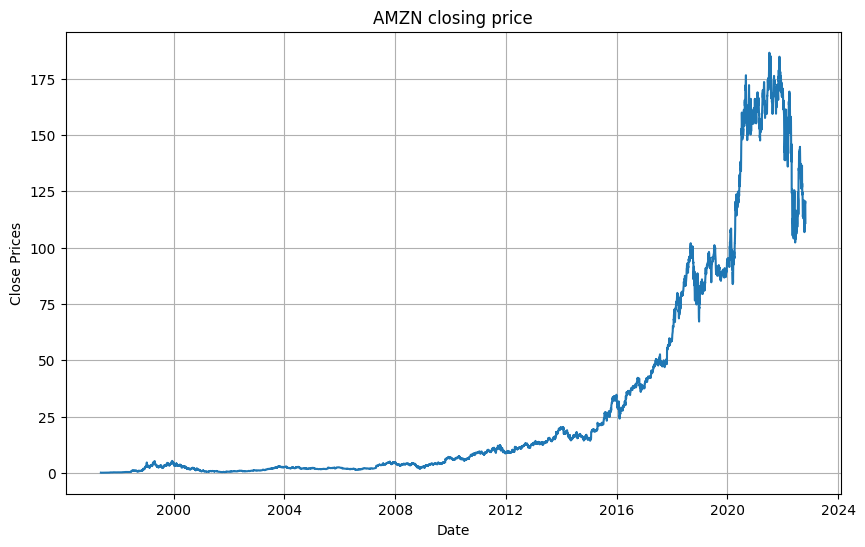

In [41]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('AMZN closing price')
plt.show()

<AxesSubplot: ylabel='Density'>

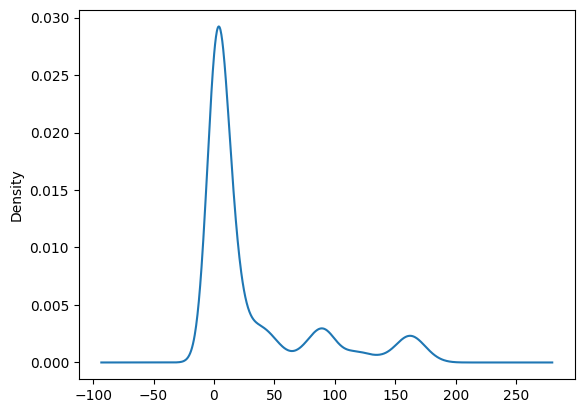

In [42]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

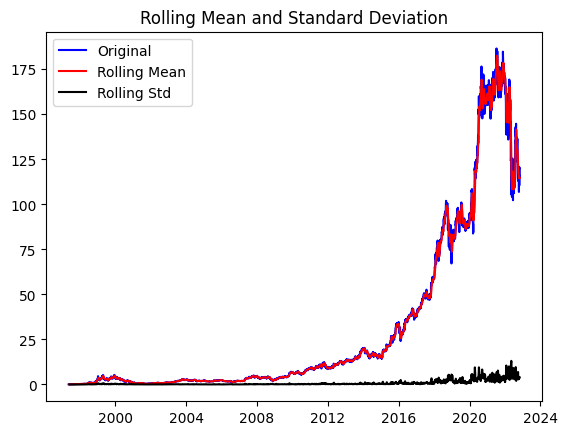

Results of dickey fuller test
Test Statistics                  -0.101182
p-value                           0.949321
No. of lags used                 34.000000
Number of observations used    6372.000000
critical value (1%)              -3.431377
critical value (5%)              -2.861994
critical value (10%)             -2.567012
dtype: float64


In [43]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

# Findings
We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

<Figure size 640x480 with 0 Axes>

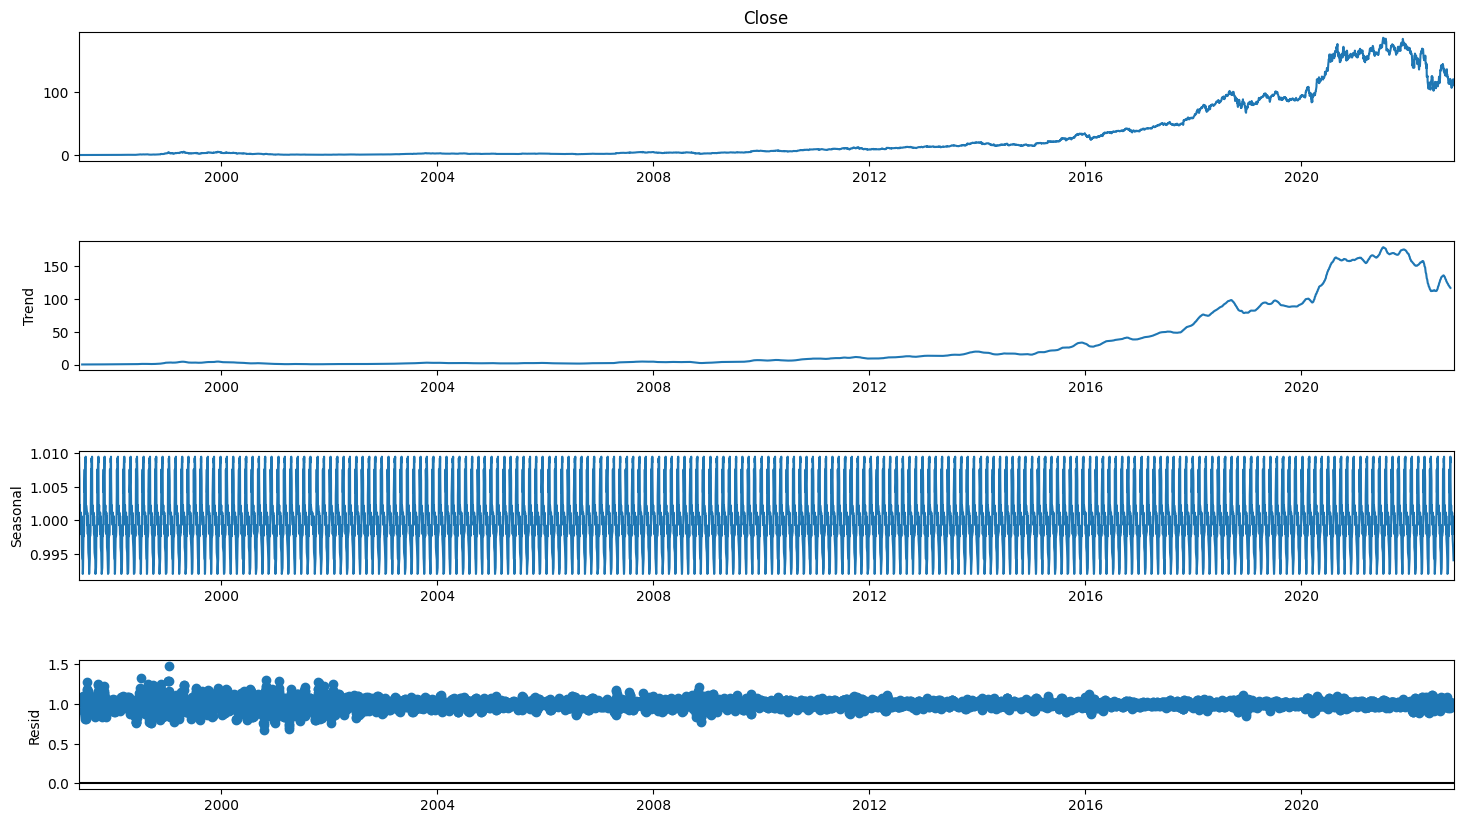

In [44]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


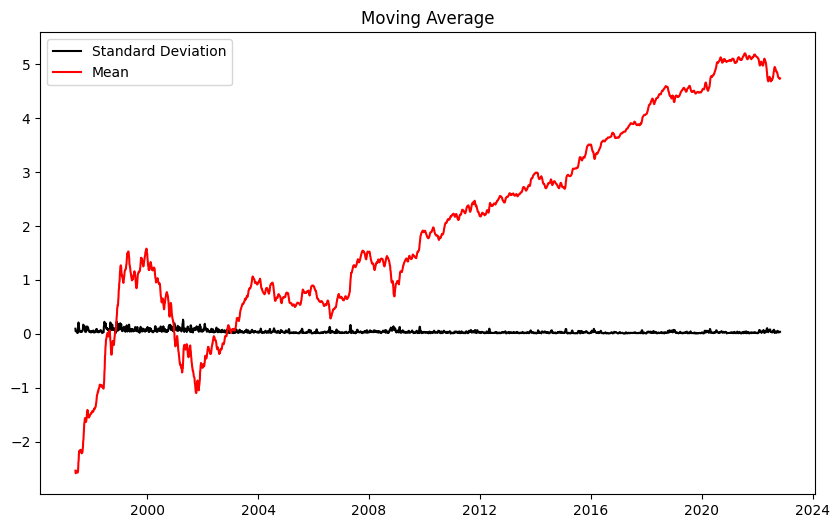

In [45]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

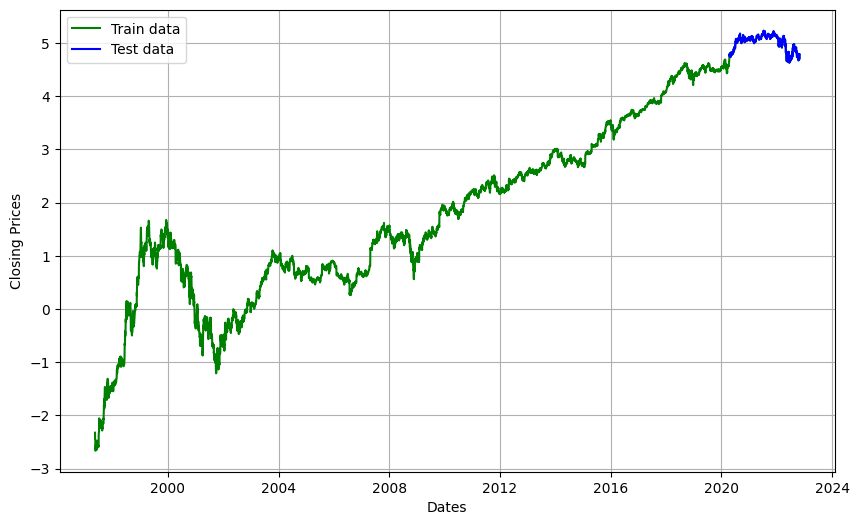

In [46]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21697.817, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21695.955, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21695.964, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21693.102, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21696.624, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.835 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5763
Model:               SARIMAX(0, 1, 0)   Log Likelihood               10850.908
Date:                Mon, 31 Oct 2022   AIC                         -21697.817
Time:                        19:51:15   BIC                         -21684.499
Sample:                             0   HQIC                        -21693.182
                               - 5763                             

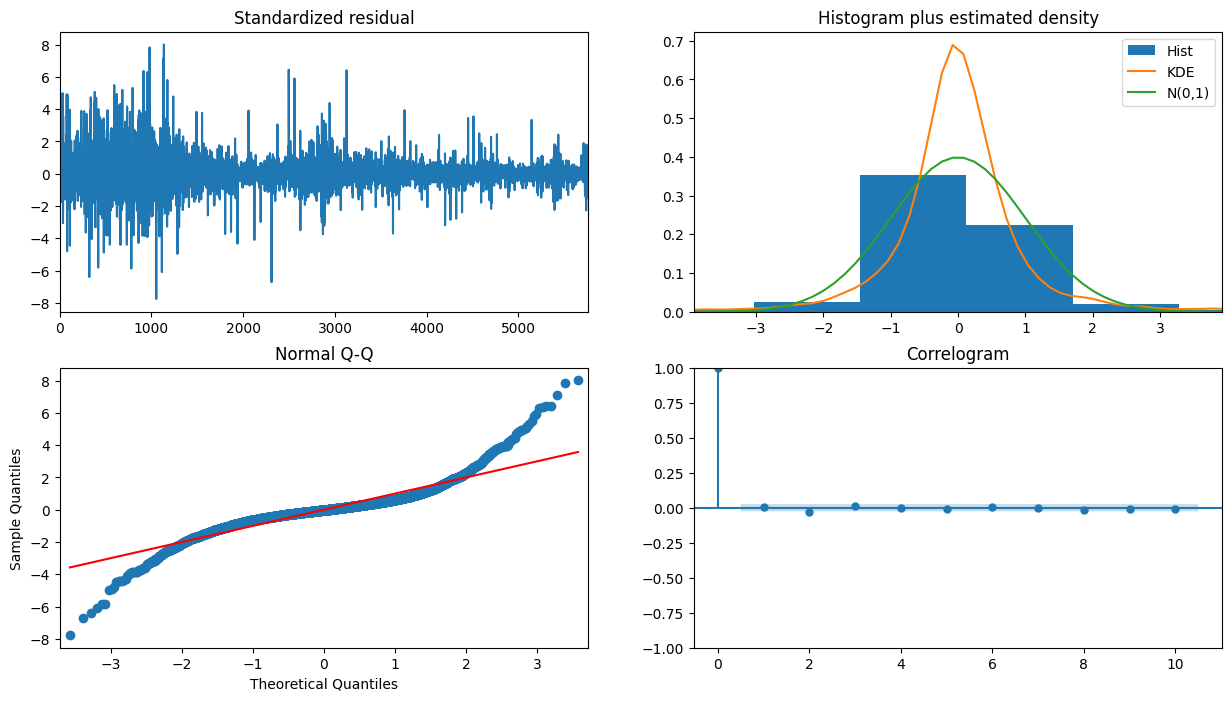

In [47]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [80]:
#Modeling
# Build Model
model = sm.tsa.arima.model.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()
print(fitted.summary())

C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5763
Model:                 ARIMA(1, 1, 2)   Log Likelihood               10850.503
Date:                Mon, 31 Oct 2022   AIC                         -21693.005
Time:                        20:13:08   BIC                         -21666.369
Sample:                             0   HQIC                        -21683.736
                               - 5763                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4196      0.223     -1.882      0.060      -0.857       0.017
ma.L1          0.4258      0.223      1.908      0.056      -0.012       0.863
ma.L2         -0.0252      0.010     -2.584      0.0

In [76]:
# Forecast
fc = fitted.forecast(641, alpha=0.05)  # 95% conf
# print(fc.shape)
# print(type(fc))
print(fc)
print(len(fc))
start = 5763
fc_arr = []
for i in range(len(fc)):
    fc_arr.append(fc[start+i])

fc_series = pd.Series(fc_arr, index=test_data.index)
print(fc_series)


# fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

5763    1.697134
5764    1.697134
5765    1.697134
5766    1.697134
5767    1.697134
          ...   
6399    1.697134
6400    1.697134
6401    1.697134
6402    1.697134
6403    1.697134
Name: predicted_mean, Length: 641, dtype: float64
641
Date
2020-04-15    1.697134
2020-04-16    1.697134
2020-04-17    1.697134
2020-04-20    1.697134
2020-04-21    1.697134
                ...   
2022-10-21    1.697134
2022-10-24    1.697134
2022-10-25    1.697134
2022-10-26    1.697134
2022-10-27    1.697134
Length: 641, dtype: float64


C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [77]:
print(train_data)
print(type(test_data))

Date
1997-05-20   -2.503833
1997-05-21   -2.640102
1997-05-22   -2.662236
1997-05-23   -2.590267
1997-05-27   -2.536196
                ...   
2020-04-07    4.610953
2020-04-08    4.626442
2020-04-09    4.626325
2020-04-13    4.686229
2020-04-14    4.737654
Name: Close, Length: 5763, dtype: float64
<class 'pandas.core.series.Series'>


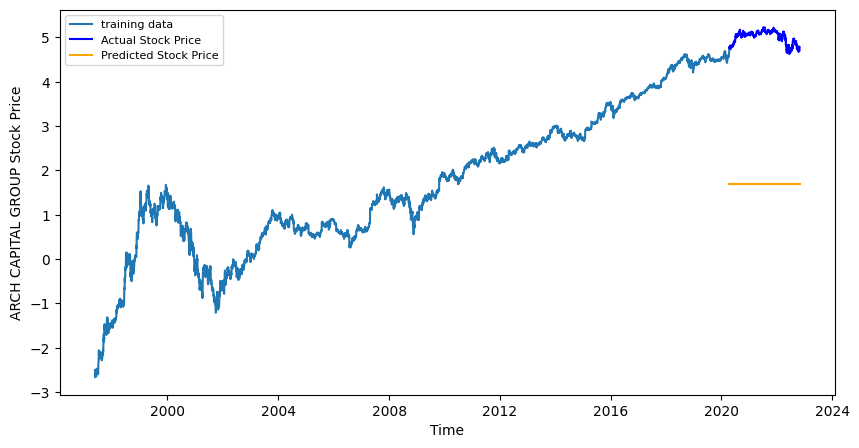

In [78]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [82]:
train_data, test_data = stock_data[0:int(len(stock_data)*0.7)], stock_data[int(len(stock_data)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

C:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

Testing Mean Squared Error is 4.864168183410084


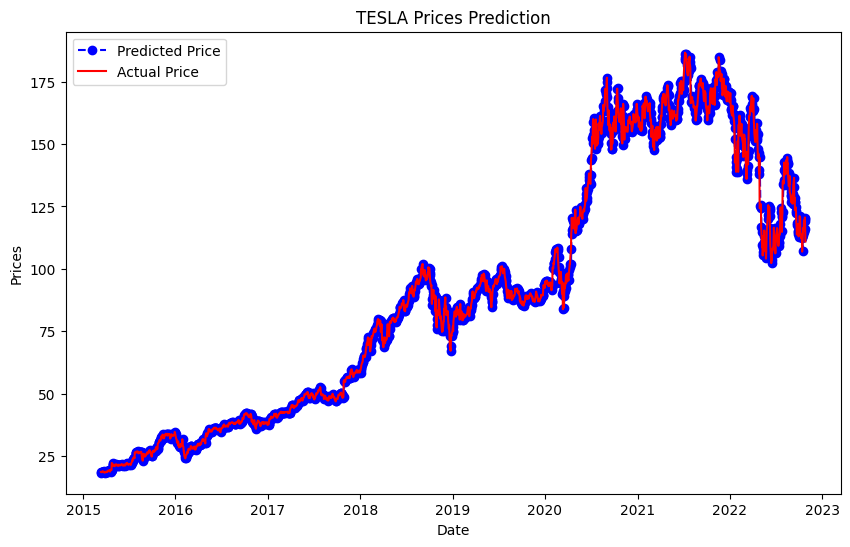

In [85]:
test_set_range = stock_data[int(len(stock_data)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [5]:
os.environ

environ{'ALLUSERSPROFILE': 'C:\\ProgramData',
        'APPDATA': 'C:\\Users\\Jignasu\\AppData\\Roaming',
        'CHOCOLATEYINSTALL': 'C:\\ProgramData\\chocolatey',
        'CHOCOLATEYLASTPATHUPDATE': '132981397537989848',
        'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
        'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
        'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
        'COMPUTERNAME': 'DESKTOP-J4EH8H2',
        'COMSPEC': 'C:\\Windows\\system32\\cmd.exe',
        'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData',
        'FPS_BROWSER_APP_PROFILE_STRING': 'Internet Explorer',
        'FPS_BROWSER_USER_PROFILE_STRING': 'Default',
        'HOMEDRIVE': 'C:',
        'HOMEPATH': '\\Users\\Jignasu',
        'LOCALAPPDATA': 'C:\\Users\\Jignasu\\AppData\\Local',
        'LOGONSERVER': '\\\\DESKTOP-J4EH8H2',
        'NUMBER_OF_PROCESSORS': '8',
        'ONEDRIVE': 'C:\\Users\\Jignasu\\OneDrive',
        'OS': 'Windows_NT'

In [20]:
load_dotenv()

# OR, the same with increased verbosity
load_dotenv(verbose=True)

# OR, explicitly providing path to '.env'
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

# Print variable FOO
print(os.environ.get('API_KEY'))

None


In [8]:
print(os.environ.get('CONSUMER_API_KEY'))

7hyjKd76f6OciQqwU1lHjiUKU


In [9]:
consumer_key = os.environ.get('CONSUMER_API_KEY')
consumer_secret = os.environ.get("CONSUMER_API_KEY_SECRET")
access_token = os.environ.get("ACCESS_TOKEN")
access_token_secret = os.environ.get("ACCESS_TOKEN_SECRET")

auth = tweepy.OAuth1UserHandler(
  consumer_key, 
  consumer_secret, 
  access_token, 
  access_token_secret
)

In [12]:
api = tweepy.API(auth)


extracted_tweets = []

for status in tweepy.Cursor(api.search_tweets, 
                            "Ukraine", 
                            lang="en",
                            tweet_mode="extended",
                            count=10).items(10):
    extracted_tweets.append(status)

In [22]:
from pprint import pp
print(len(extracted_tweets))
# print(type(extracted_tweets[0]))
# print(extracted_tweets[0].created_at)
# print(extracted_tweets[0].full_text)
# print(extracted_tweets[0].retweeted_status.)
# print(extracted_tweets[0].retweeted_status.full_text)
# print(extracted_tweets[2].retweeted_status.truncated)
# pp(extracted_tweets[5], depth=6)
# pd.DataFrame(extracted_tweets[5]._json)
pp(extracted_tweets[8]._json)




# print(json.dumps((json.loads(str(extracted_tweets[0]))), indent = 5))

10
{'created_at': 'Thu Nov 10 16:42:56 +0000 2022',
 'id': 1590746840688754693,
 'id_str': '1590746840688754693',
 'full_text': 'RT @The_ONR: We’re delighted to be hosting the Western European '
              'Nuclear Regulators Association meeting today at the Museum of '
              'Liverpool.…',
 'truncated': False,
 'display_text_range': [0, 137],
 'entities': {'hashtags': [],
              'symbols': [],
              'user_mentions': [{'screen_name': 'The_ONR',
                                 'name': 'Office for Nuclear Regulation',
                                 'id': 532301381,
                                 'id_str': '532301381',
                                 'indices': [3, 11]}],
              'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/android" '
           'rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_u

In [31]:
print(json.dumps((json.loads(extracted_tweets)), indent = 5))

JSONDecodeError: Expecting value: line 1 column 2 (char 1)

In [14]:
api = tweepy.API(auth)

In [15]:
extracted_tweets = []

In [25]:
tod = datetime.now()
d = timedelta(days = 2)
start_time = tod - d
end_time = start_time - d
print("start_time = ", start_time)
print("end_time = ", end_time)


start_time =  2022-11-08 11:55:09.752754
end_time =  2022-11-06 11:55:09.752754


In [14]:
client = tweepy.Client(os.environ.get("BEARER_TOKEN"))

In [26]:
res = client.search_all_tweets("Jeff Bezos", start_time=start_time, end_time=end_time, expansions=None, max_results=2, media_fields=None, next_token=None, place_fields=None, poll_fields=None, since_id=None, sort_order=None, tweet_fields=None, until_id=None, user_fields=None)

Unauthorized: 401 Unauthorized
Unauthorized

# Starting data collection

In [2]:
load_dotenv()

# OR, the same with increased verbosity
load_dotenv(verbose=True)

# OR, explicitly providing path to '.env'
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

consumer_key = os.environ.get('CONSUMER_API_KEY')
consumer_secret = os.environ.get("CONSUMER_API_KEY_SECRET")
access_token = os.environ.get("ACCESS_TOKEN")
access_token_secret = os.environ.get("ACCESS_TOKEN_SECRET")

auth = tweepy.OAuth1UserHandler(
  consumer_key, 
  consumer_secret, 
  access_token, 
  access_token_secret
)

In [27]:
api = tweepy.API(auth)


extracted_tweets = []

for status in tweepy.Cursor(api.search_tweets, 
                            "Ukraine", 
                            lang="en",
                            start_time=start_time, 
                            end_time=end_time,
                            count=10).items(10):
    extracted_tweets.append(status)

Unexpected parameter: start_time
Unexpected parameter: end_time


In [3]:
client = tweepy.Client(os.environ.get("BEARER_TOKEN"))

In [4]:
query = 'covid'
tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)

for tweet in tweets.data:
    print(tweet.text)
    if len(tweet.context_annotations) > 0:
        print(tweet.context_annotations)

RT @ICANdecide: FDA Director Violates FDA’s COVID Vaccine EUA

https://t.co/sx6fkiCu0o
[{'domain': {'id': '123', 'name': 'Ongoing News Story', 'description': "Ongoing News Stories like 'Brexit'"}, 'entity': {'id': '1220701888179359745', 'name': 'COVID-19'}}, {'domain': {'id': '131', 'name': 'Unified Twitter Taxonomy', 'description': 'A taxonomy of user interests. '}, 'entity': {'id': '1220701888179359745', 'name': 'COVID-19'}}]
RT @ChrisLusardi1: @backtolife_2023 The zero covid policy in China is absolutely brutal and demoralizing.
[{'domain': {'id': '123', 'name': 'Ongoing News Story', 'description': "Ongoing News Stories like 'Brexit'"}, 'entity': {'id': '1220701888179359745', 'name': 'COVID-19'}}, {'domain': {'id': '131', 'name': 'Unified Twitter Taxonomy', 'description': 'A taxonomy of user interests. '}, 'entity': {'id': '1220701888179359745', 'name': 'COVID-19'}}]
RT @Kerstigirl: @Wolfiesmom Elon’s sole purpose is to disseminate this site asap. Too many medical experts discussing

In [174]:
query = 'covid'

# Replace with time period of your choice
start_time = '2020-01-01T00:00:00Z'

# Replace with time period of your choice
end_time = '2020-08-01T00:00:00Z'

tweets = client.search_all_tweets(query=query, tweet_fields=['lang', 'context_annotations', 'created_at', 'possibly_sensitive', 'public_metrics'],
                                  start_time=start_time,
                                  end_time=end_time, sort_order="relevancy", max_results=10)

for tweet in tweets.data:
    print(tweet.id)
    print(tweet.text)
    print(tweet.lang)
    print(tweet.created_at)
    # print(tweet)
    print(tweet.public_metrics)
    print(tweet.public_metrics["retweet_count"])
    break
    # print(tweet.possibly_sensitive)
    

1289339616126853121
Covid-19 is killing at least 1000 people every day. So, say a passenger plane carries about 200 people.  America is experiencing the equivalent of five plane crashes each day.  Are we starting to feel like this is normal?
en
2020-07-31 23:18:13+00:00
{'retweet_count': 6604, 'reply_count': 538, 'like_count': 26546, 'quote_count': 237}
6604


In [54]:
tod = datetime.now()
d = timedelta(hours = 6)
end_time = tod - d
start_time = end_time - d
print("start_time = ", start_time)
print("end_time = ", end_time)


start_time =  2022-11-10 00:33:42.198112
end_time =  2022-11-10 06:33:42.198112


In [62]:
year = timedelta(days=365)
print(year < (end_time - start_time))

False


In [134]:
date = "2022-01-04"
date = datetime.strptime(date, '%Y-%m-%d')
print(date)
print(date.strftime("%B"))
# date = date.strftime("%d/%m/%Y %H:%M:%S")
date = date.strftime("%Y-%m-%d")
print(date)


2022-01-04 00:00:00
January
2022-01-04


In [24]:
df = pd.DataFrame()

In [7]:
tweets = None

def fetch_data_for_days(begin, end, query):
    global df
    global tweets
    # period = timedelta(days=days_delta)
    six_hours = timedelta(hours=6)
    loop_time = timedelta(seconds=5)
    begin = datetime.strptime(begin, '%Y-%m-%d')
    end = datetime.strptime(end, '%Y-%m-%d')
    end_time = begin
    period = begin-end
    while(period > begin - end_time):
        print(end_time)
        start_loop_time = datetime.now()
        start_time = end_time - six_hours
        tweets = client.search_all_tweets(query=query, tweet_fields=['lang', 'context_annotations', 'created_at', 'possibly_sensitive', 'public_metrics'],
                                  start_time=start_time,
                                  end_time=end_time, sort_order="relevancy", max_results=60)
        for tweet in tweets.data:
            if(tweet.lang!="en"):
                try:
                    tweet.text = GoogleTranslator(source=tweet.lang, target='en').translate(tweet.text)
                except:
                    continue
            sentiment = getSentiment(tweet.text)
            df = df.append({"id": tweet.id, 
                       "date": tweet.created_at , 
                       "text": tweet.text, 
                       "retweet_count": tweet.public_metrics["retweet_count"], 
                       "reply_count": tweet.public_metrics["reply_count"], 
                       "like_count": tweet.public_metrics["like_count"],
                       "quote_count": tweet.public_metrics["quote_count"],
                       "negative": sentiment[0],
                       "neutral": sentiment[1],
                       "positive": sentiment[2]
                      }, ignore_index=True)
        end_time = start_time
        end_loop_time = datetime.now()
        diff = loop_time.total_seconds() - (end_loop_time-start_loop_time).total_seconds()
        if(diff>0):
            time.sleep(diff)
    file_name = begin.strftime("%Y") + " " + begin.strftime("%B") + ".csv"
    df.to_csv("extracted_data/"+file_name)
    return datetime.strftime(end_time, '%Y-%m-%d')

In [178]:
six_hours = timedelta(hours=6)
loop_time = timedelta(seconds=5)
start_loop_time = datetime.now()
time.sleep(loop_time.total_seconds())
end_loop_time = datetime.now()
print(loop_time.total_seconds())
print((end_loop_time - start_loop_time).total_seconds())

5.0
5.003277


In [32]:
import warnings
warnings.filterwarnings('ignore')
print(fetch_data_for_days("2022-01-04", "2022-01-02", "marvel"))

2022-01-04 00:00:00
2022-01-03 18:00:00
2022-01-03 12:00:00
2022-01-03 06:00:00
2022-01-03 00:00:00
2022-01-02 18:00:00
2022-01-02 12:00:00
2022-01-02 06:00:00
2022-01-02


In [33]:
df.head(2)

,id,date,text,retweet_count,reply_count,like_count,quote_count,negative,neutral,positive
0,1478093808684384262,2022-01-03 20:00:00+00:00,"Hey bro, learn how to be in the Tracksuit Mafi...",537,80,7319,64,0.002567,0.48363,0.513802
1,1478093809737211907,2022-01-03 20:00:00+00:00,"Hey bro, learn how to be in the Tracksuit Mafi...",177,33,2446,25,0.002567,0.48363,0.513802


In [109]:
df.set_index("id")

,date,text,retweet_count,reply_count,like_count,quote_count,negative,neutral,positive
id,,,,,,,,,
1590655638379851777,2022-11-10 10:40:31+00:00,Tom Holland aurait signé un accord avec Marvel...,647,35,5168,237,0.016879,0.816717,0.166404
1590645965287206912,2022-11-10 10:02:05+00:00,😂 https://t.co/QUSOODEcwg,894,174,4366,252,0.208365,0.549426,0.242209
1590669478433787905,2022-11-10 11:35:31+00:00,Dedicated to our friend Chadwick Boseman,475,9,2593,34,0.003044,0.422449,0.574507
1590693025428443137,2022-11-10 13:09:05+00:00,"""Born Again"", a segunda música da Rihanna para...",99,19,946,44,0.024883,0.891509,0.083607
1590653064671002624,2022-11-10 10:30:18+00:00,"Les origines tragiques de Patton Parnel, le Sp...",408,25,2994,24,0.072784,0.862197,0.065019
...,...,...,...,...,...,...,...,...,...
1590339031233335297,2022-11-09 13:42:26+00:00,this was on submitters iPad for years https://...,363,27,5427,14,0.071987,0.839563,0.088450
1590391112664875008,2022-11-09 17:09:23+00:00,Dragonball Super - Page 49\nSee more pages &am...,705,7,6477,0,0.002808,0.671163,0.326029
1590379967799382017,2022-11-09 16:25:06+00:00,In the middle of an endless stream of Jim Lee ...,59,12,484,3,0.013430,0.130387,0.856183


In [121]:
for ind, row in df.iterrows():
    if(ind==9):
        print(row.text)
        break

Avec 243 470 entrées, le film Marvel "Black Panther: #WakandaForever" réalise le 4ème meilleur démarrage de l'année en France.

(via @boxofficefr) https://t.co/G1nJ7gzCkb


# Final code for period of 1 month CSVs

In [8]:
from dateutil.relativedelta import relativedelta
tweets = None
def fetch_data(query, upto, forMonths):
    latest_date = upto
    # latest_date = "2022-10-31"
    latest_date = datetime.strptime(latest_date, '%Y-%m-%d')
    delta = relativedelta(months=1)
    delta = relativedelta(days=1)
    for months in range(forMonths):
        first_date = latest_date - delta
        print(first_date)
        df = pd.DataFrame()
        latest_date = fetch_data_for_days(latest_date.strftime('%Y-%m-%d'), first_date.strftime('%Y-%m-%d'), query)
        latest_date = datetime.strptime(latest_date, '%Y-%m-%d')


In [9]:
tweets = None
fetch_data("amazon business news", "2022-10-31", 1)

2022-10-30 00:00:00
2022-10-31 00:00:00


NameError: name 'getSentiment' is not defined

In [158]:
getSentiment("Apple sold slightly fewer iPhones than expected, but Tim Cook says the economy isn't yet affecting sales \u2013 bucking the Big economy isn't yet affecting sales \u2013 bucking the Big economy isn't yet affecting sales \u2013 bucking the Big economy isn't yet affecting sales \u2013 bucking the Big economy isn't yet affecting sales \u2013 bucking the Big economy isn't yet affecting sales \u2013 bucking the Big  economy isn't yet affecting sales \u2013 bucking the Big Tech bad-news trend")

[0.27444768, 0.55302584, 0.17252652]

In [26]:
tweets


Response(data=[<Tweet id=1478076384555667457 text='🍿PREPÁRENSE | La duración final de Doctor Strange in the Multiverse of Madness sería de 3 horas, siendo la segunda película de Marvel Studios con mayor duración, solo detrás de Avengers Endgame. \n\n🎬 Estreno en cines 5 de Mayo.\n\n🗣Vía Moth_Culture https://t.co/hvPC0A81ln'>, <Tweet id=1478093808684384262 text='Hey bro, learn how to be in the Tracksuit Mafia bro! All episodes of Marvel Studios’ @HawkeyeOfficial are now streaming on @DisneyPlus. https://t.co/OznbPnWEbw'>, <Tweet id=1478144911010578432 text='A Sony e a Marvel Studios submeteram #SpiderManNoWayHome a todas as categorias do Oscar, incluindo a de "Melhor Filme" https://t.co/AhEBxcc7b1'>, <Tweet id=1478086234027302913 text="¡OJO! Parece ser que Sony y Marvel Studios presentan 'SPIDER-MAN NO WAY HOME' a todas las categorias de los Oscar. https://t.co/7LDYrVYMDB">, <Tweet id=1478093809737211907 text='Hey bro, learn how to be in the Tracksuit Mafia bro! All episodes of Marvel S

In [40]:
def translate(input_text, source_lang, target_lang):
    translated = GoogleTranslator(source=source_lang, target=target_lang).translate_sentences(input_text)
    return translated

In [28]:
# translator = Translator()
# translator = Translator(service_urls=['translate.googleapis.com'])
translator= Translator(to_lang="en")
for tweet in tweets.data:
    if(tweet.lang !="en"):
        # print(tweet.lang)
        # translation = translator.translate("kem co", dest='en')
        translated = GoogleTranslator(source=tweet.lang, target='en').translate(tweet.text)  # output -> Weiter so, du bist großartig
        # translation = translator.translate(tweet.text)
        print("original text: ",tweet.text)
        print("Translation: ", translated)
        break
        # translate(tweet.text, tweet.lang, "en")

original text:  🍿PREPÁRENSE | La duración final de Doctor Strange in the Multiverse of Madness sería de 3 horas, siendo la segunda película de Marvel Studios con mayor duración, solo detrás de Avengers Endgame. 

🎬 Estreno en cines 5 de Mayo.

🗣Vía Moth_Culture https://t.co/hvPC0A81ln
Translation:  🍿 GET READY | The final duration of Doctor Strange in the Multiverse of Madness would be 3 hours, being the second Marvel Studios film with the longest duration, only behind Avengers Endgame.

🎬 Premiere in theaters May 5th.

🗣 Via Moth_Culture https://t.co/hvPC0A81ln


In [2]:
from google_trans_new import google_translator  
translator = google_translator()  
translate_text = translator.translate('สวัสดีจีน',lang_tgt='en')  
print(translate_text)


ImportError: attempted relative import with no known parent package

In [34]:
from translate import Translator
translator= Translator(to_lang="German")
translation = translator.translate("")
print(translation)

02-10-2006, 21:04


In [5]:
translated = GoogleTranslator(source='auto', target='de').translate("keep it up, you are awesome")  # output -> Weiter so, du bist großartig


In [6]:
print(translated)

weiter so, du bist toll
